## Creating a data set

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math
%matplotlib inline

In [2]:
def change_nan(value):   #function changing nan into 0 and 'tak' into 1
    for i in range(len(value)):
        try:
            if math.isnan(value[i]):
                value[i]=0
        except:
            if value[i]=='Tak':
                value[i]=1
            elif value[i]=='tak':
                value[i]=1  
        
    return value

def clean_guarantee(value):
    try:
        return int(value.split()[0])
    except:
        return value
    
def clean_instalment(x):
    if x=='0':
        return int(x)
    else:
        return int(''.join(x.split()[:-1]))
    
def change_price(x):
    return int(''.join(x.split('PLN')[0].split()))
    
def change_date(x): #change string into datetime object
    try:
        if math.isnan(x):
            return 0
    except:
        pass
    if x=='0':
        return int(x)
    elif x==0:
        return x
    else:
        x=x.split()[0]
        return datetime.strptime(x, '%d/%m/%Y')
    
def guarantee_left(x): #how many months of guarantee left
    if x==0:
        return 0
    if x.year>datetime.now().year:
        time_left= (12-datetime.now().month)+(x.year-datetime.now().year-1)*12+x.month
        if time_left<0:
            return 0
        else:
            return time_left
    else:
        time_left=x.month-datetime.now().month
        if time_left<0:
            return 0
        else:
            return time_left

In [3]:
# getting info about one car
def get_info2(url):
    try:
        car_info={}
        soup=bs(requests.get(url).content)
        car_info['price']=soup.find(class_='offer-price__number').get_text(strip=True)
        parameters=soup.find(class_='parametersArea').find_all('li')
        for i in range(len(parameters)):
            try:
                key=parameters[i].find(class_='offer-params__label').get_text(strip=True)
                value=parameters[i].find(class_='offer-params__value').get_text(strip=True)
                car_info[key]=value
            except:
                continue

        features=soup.find(class_='offer-features').find_all('li')
        car_info['num of features']=len(features)
        
        return car_info
    except:
        pass

In [ ]:
#creating list of directories about cars
list_of_cars=[]
for j in range(4):
    print('j={}'.format(j))
    for k in range(60):
        print(k)
        soup=bs(requests.get('https://www.otomoto.pl/osobowe/?search%5Bfilter_float_price%3Afrom%5D={}0000'.format(j+1)+'&search%5Bfilter_float_price%3Ato%5D={}0000'.format(j+2)+'&search%5Bfilter_float_year%3Ato%5D=2018&search%5Bfilter_enum_damaged%5D=0&search%5Border%5D=created_at%3Adesc&search%5Bbrand_program_id%5D%5B0%5D=&search%5Bcountry%5D=&page={}'.format(k+1)).content)
        offers_lst=soup.find(class_='offers list').find_all(class_='offer-item__title')
        for i in range(len(offers_lst)):
            link=offers_lst[i].a['href']
            list_of_cars.append(get_info2(link))

In [8]:
#removing None objects in list_of_cars
length=len(list_of_cars)
for i in range(length):
    if list_of_cars[i]==None:
        list_of_cars.remove(list_of_cars[i])
        length=len(list_of_cars)

In [9]:
#creating a data frame
df=pd.DataFrame(list_of_cars)

In [10]:
len(df.columns)

49

In [14]:
df.to_csv('otomoto 3')

We will create seperate data frame for cars which have steering wheel on the right or which are antique.

In [18]:
#cars that has steering wheel on the right or which are antique
df1=df[(df['Kierownica po prawej (Anglik)']=='Tak')|(df['Zarejestrowany jako zabytek'].isnull()!=True)]

In [26]:
df1[df1['Zarejestrowany jako zabytek'].isnull()!=True][['Marka pojazdu','Model pojazdu','Rok produkcji','Zarejestrowany jako zabytek']]

,Marka pojazdu,Model pojazdu,Rok produkcji,Zarejestrowany jako zabytek
3272,Audi,A3,2011,Tak
3567,Opel,Astra,2011,Tak
3729,BMW,Seria 5,2010,Tak
4673,Toyota,Yaris,2015,Tak
4790,Škoda,Superb,2012,Tak
6273,Volkswagen,Sharan,2015,Tak


This cars doesn't seem to be an antique so we will remove them from our data frame. We will also remove cars with steering wheel on the right and cars with unpaid credit because there are just a few cars like that and they may not fit into our model.

In [8]:
#removing cars with steering wheel on the right or which are antique
df.drop(df[df['Kierownica po prawej (Anglik)']=='Tak'].index,inplace=True)
df.drop(df[df['Liczba pozostałych rat'].isnull()!=True].index,inplace=True)
df.drop(df[df['Zarejestrowany jako zabytek'].isnull()!=True].index,inplace=True)
df.drop('Kolor',axis=1,inplace=True)

In [9]:
df=df.reset_index(drop=True)

Now we will deal with missing values.

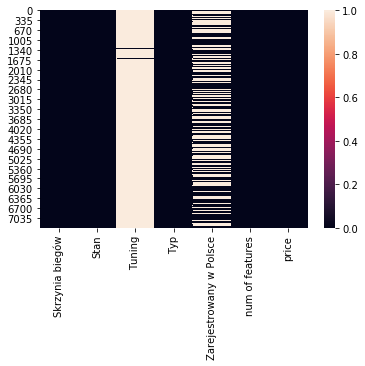

In [149]:
sns.heatmap(df[df.columns[20:40]].isnull())

We will remove columns which are unnecessary or which have too much nan values.

In [ ]:
#removin columns which are unnecessary or which have too much nan values
df.drop(['Emisja CO2','Faktura VAT','Generacja','Homologacja ciężarowa','Kierownica po prawej (Anglik)',
        'Kod Silnika','Leasing','Liczba pozostałych rat','Miesięczna rata','Możliwość finansowania',
        'Numer rejestracyjny pojazdu','Opłata początkowa','Pierwsza rejestracja','VAT marża','Wartość wykupu','Wersja',
        'Zarejestrowany jako zabytek','lub do (przebieg km)','Liczba drzwi','Liczba miejsc','Napęd'],axis=1,inplace=True)

Missing values in country of origin column we will set as Polska because I think that is the most probably value and this might be important for our model.

In [13]:
#changing NaN values in 'Kraj pochodzenia' into Polska
for i in range(df['price'].count()):
    try:
        if math.isnan(df['Kraj pochodzenia'][i]):
            df['Kraj pochodzenia'][i]='Polska'
    except:
        continue

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


We will remove cars with missing values in columns power, capacity of an engine and gear box.

In [ ]:
#removing rows with missing values
df.drop(df[df['Moc'].isnull()==True].index,inplace=True)
df.drop(df[df['Pojemność skokowa'].isnull()==True].index,inplace=True)
df.drop(df[df['Skrzynia biegów'].isnull()==True].index,inplace=True)
df.drop(df[df['price']=='5 600EUR'].index,inplace=True)

In the rest of columns when we have missing value it means that a given car doesn't have a feature which this column represents, so we will fill this fields with 0, and if a given car does have some feature we will set 1.

In [17]:
#changing nan values into 0 and 'Tak' into 1
df=df.apply(change_nan)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [33]:
df['Stan'].unique()

array(['Używane'], dtype=object)

In [34]:
df['Kategoria'].unique()

array(['Osobowe'], dtype=object)

We will remove unnecessary columns category and condition, because every car has the same value in this columns.

In [86]:
#removing unnecessary clumns
df.drop('Stan',axis=1,inplace=True)
df.drop('Kategoria',axis=1,inplace=True)

In [111]:
df=df.reset_index(drop=True)

Now we will change format of some columns, from string into float or date.time object.

In [48]:
#changing format of some columns
df['Moc']=df['Moc'].apply(clean_guarantee)
df['Pojemność skokowa']=df['Pojemność skokowa'].apply(clean_instalment)
df['Przebieg']=df['Przebieg'].apply(clean_instalment)
df['price']=df['price'].apply(change_price)
df['Okres gwarancji producenta']=df['Okres gwarancji producenta'].apply(change_date)
df['Gwarancja dealerska (w cenie)']=df['Gwarancja dealerska (w cenie)'].apply(clean_guarantee)

We will fix values in Metalik column. Instead of 'metallic' there shoud be 1.

In [37]:
#fixing values in 'Metalik' column
for i in range(df['price'].count()):
    if df[df.columns[7]][i]=='metallic':
        df[df.columns[7]][i]=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We will create a new column informing about how much guarantee has left.

In [ ]:
for i in range(df['price'].count()):
    if df['Gwarancja dealerska (w cenie)'][i]!=0:
        df['guarantee left'][i]=df['Gwarancja dealerska (w cenie)'][i]
    else:
        df['guarantee left'][i]=guarantee_left(df['Okres gwarancji producenta'][i])

In [179]:
df.columns

Index(['Akryl (niemetalizowany)', 'Bezwypadkowy', 'Filtr cząstek stałych',
       'Gwarancja dealerska (w cenie)', 'Kraj pochodzenia', 'Marka pojazdu',
       'Matowy', 'Metalik', 'Moc', 'Model pojazdu', 'Oferta od',
       'Okres gwarancji producenta', 'Perłowy', 'Pierwszy właściciel',
       'Pojemność skokowa', 'Przebieg', 'Rodzaj paliwa', 'Rok produkcji',
       'Serwisowany w ASO', 'Skrzynia biegów', 'Tuning', 'Typ',
       'Zarejestrowany w Polsce', 'num of features', 'price',
       'guarantee left'],
      dtype='object')

Now we will change some columns into categorical.

In [184]:
#Changing some columns into categorical

df=pd.concat([df,pd.get_dummies(df['Marka pojazdu'])],axis=1)
#df1.drop('Marka pojazdu',axis=1,inplace=True)

df=pd.concat([df,pd.get_dummies(df['Model pojazdu'])],axis=1)
#df1.drop('Model pojazdu',axis=1,inplace=True)

df=pd.concat([df,pd.get_dummies(df['Oferta od'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Rodzaj paliwa'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Skrzynia biegów'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Typ'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Kraj pochodzenia'])],axis=1)

In [36]:
df=df.rename(columns={'Model pojazdu':'model','Marka pojazdu':'brand','Moc':'power','Rok produkcji':'year of production',
            'Pojemność skokowa':'capacity of an engine','Przebieg':'mileage'})

In [187]:
df.to_csv('otomoto clean 3')

## Exploratory data analysis

In [3]:
df=pd.read_csv('otomoto clean 3')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
important_params=['model','brand','power','year of production','capacity of an engine','mileage','price']

Let's see how a distubution of a price, a mileage, a year of production and a power looks like.

(array([254., 335., 360., 404., 436., 323., 375., 360., 367., 411., 308.,
        380., 380., 353., 398., 323., 381., 411., 353., 399.]),
 array([10000., 12000., 14000., 16000., 18000., 20000., 22000., 24000.,
        26000., 28000., 30000., 32000., 34000., 36000., 38000., 40000.,
        42000., 44000., 46000., 48000., 50000.]),
 <a list of 20 Patch objects>)

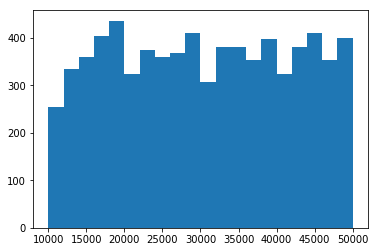

In [5]:
plt.hist(df['price'],bins=20)

In [200]:
pd.DataFrame(df['mileage'].unique()).sort_values(by=0)

,0
1123,163
2732,165
2906,911
836,1500
3059,7000
2714,7200
1955,7782
3501,8574
2436,8600
2405,9000


(array([ 42., 160., 253., 304., 441., 520., 591., 719., 748., 722., 812.,
        519., 417., 334., 210., 208.,  99.,  83.,  43.,  31.]),
 array([1.6300000e+02, 1.8604850e+04, 3.7046700e+04, 5.5488550e+04,
        7.3930400e+04, 9.2372250e+04, 1.1081410e+05, 1.2925595e+05,
        1.4769780e+05, 1.6613965e+05, 1.8458150e+05, 2.0302335e+05,
        2.2146520e+05, 2.3990705e+05, 2.5834890e+05, 2.7679075e+05,
        2.9523260e+05, 3.1367445e+05, 3.3211630e+05, 3.5055815e+05,
        3.6900000e+05]),
 <a list of 20 Patch objects>)

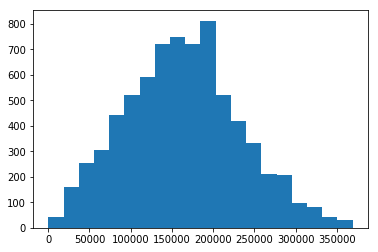

In [9]:
plt.hist(df['mileage'],bins=20)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 8.000e+00, 6.000e+00, 1.200e+01, 2.000e+01,
        1.200e+01, 9.200e+01, 1.620e+02, 9.400e+02, 1.805e+03, 1.383e+03,
        1.735e+03, 1.097e+03]),
 array([1966. , 1968.6, 1971.2, 1973.8, 1976.4, 1979. , 1981.6, 1984.2,
        1986.8, 1989.4, 1992. , 1994.6, 1997.2, 1999.8, 2002.4, 2005. ,
        2007.6, 2010.2, 2012.8, 2015.4, 2018. ]),
 <a list of 20 Patch objects>)

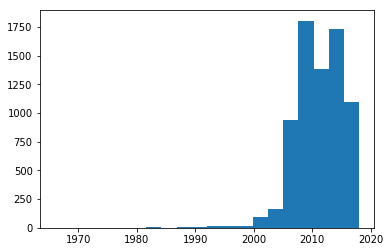

In [219]:
plt.hist(df['year of production'],bins=20)

(array([4.000e+00, 4.000e+00, 5.620e+02, 1.377e+03, 1.928e+03, 1.932e+03,
        7.960e+02, 2.180e+02, 1.640e+02, 8.900e+01, 6.600e+01, 2.900e+01,
        1.500e+01, 1.700e+01, 7.000e+00, 1.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00]),
 array([  5.,  31.,  57.,  83., 109., 135., 161., 187., 213., 239., 265.,
        291., 317., 343., 369., 395., 421., 447., 473., 499., 525.]),
 <a list of 20 Patch objects>)

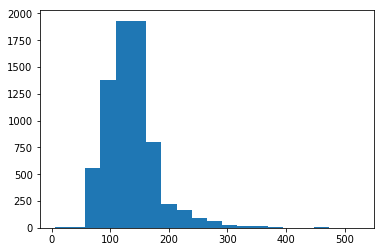

In [254]:
plt.hist(df['power'],bins=20)

## mean price for brands

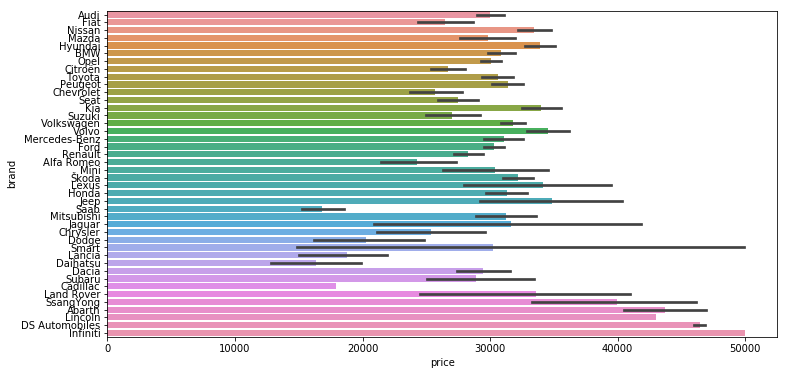

In [19]:
fig,axes=plt.subplots(figsize=(12,6))
sns.barplot(y='brand',x='price',data=df)

Let's sort brands by a mean price. 

In [92]:
pd.DataFrame(df.groupby('brand').mean()['price']).sort_values(by='price',ascending=False)

,price
brand,
Infiniti,50000.000000
DS Automobiles,46431.500000
Abarth,43700.000000
Lincoln,43000.000000
SsangYong,39950.000000
Jeep,34851.250000
Volvo,34545.798913
Lexus,34156.266667
Kia,34001.697479


## most popular brands

In [38]:
pd.DataFrame(df.groupby('brand').count()['price']).rename(columns={'price':'amount of offers'}).sort_values(by='amount of offers',ascending=False)

,amount of offers
brand,
Opel,781
Ford,778
Volkswagen,698
Audi,483
BMW,465
Renault,395
Toyota,377
Škoda,364
Peugeot,307


## cars with biggest power

In [66]:
df1[df1['mileage']<=200000][important_params].sort_values(by='power',ascending=False)

,model,brand,power,year of production,capacity of an engine,mileage,price
418,Klasa S,Mercedes-Benz,388,2006,5461,199000,47900
234,Durango,Dodge,335,2005,5654,135680,25000
357,Seria 6,BMW,333,2004,4398,180000,36900
275,Seria 3,BMW,306,2007,2979,147300,39900
470,S80,Volvo,304,2012,2953,114266,49900
117,XC 90,Volvo,272,2007,2922,38000,18400
270,Leon,Seat,265,2010,1984,143400,36900
347,A3,Audi,250,2005,3200,179000,32323
420,X3,BMW,245,2013,1997,117000,48900
406,S60,Volvo,245,2014,1969,140000,46500


## distribution of a price for cars with different mileage

In [29]:
bins=[0,50000,100000,150000,200000,250000,300000,350000,float('inf')]
df['mileage category']=pd.cut(df['mileage'],bins,labels=[1,2,3,4,5,6,7,8])

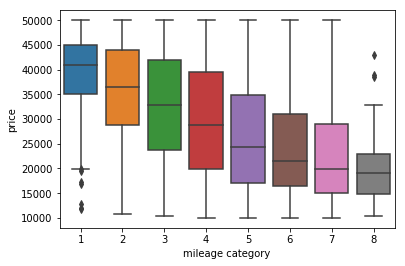

In [31]:
sns.boxplot(x='mileage category',y='price',data=df)

A mileage category 1 means mileage between 0 and 50000, a mileage category 2 means mileage between 50000 and 100000, a mileage category 3 means mileage between 100000 and 150000 etc.

## distribution of a price for cars with different power

In [38]:
bins=[0,100,150,200,250]
df['power category']=pd.cut(df['power'],bins,labels=[1,2,3,4])

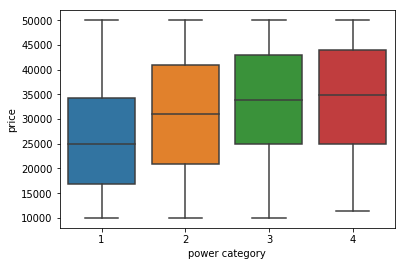

In [39]:
sns.boxplot(x='power category',y='price', data=df)

A power category 1 means a power between 0 and 100, a power category 2 means a power between 100 and 150, a power category 3 means a power between 150 and 200, etc.

## distribution of a price for cars produced in different years

In [ ]:
bins=[float('-inf'),2000,2003,2006,2009,2012,2016,2018]
df2=pd.DataFrame(pd.cut(df['year of production'],bins,labels=[1,2,3,4,5,6,7])).rename(columns={'year of production':'year category'})
df2

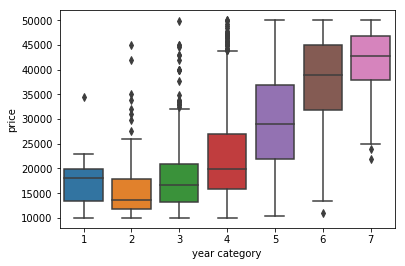

In [35]:
sns.boxplot(x='year category',y='price',data=pd.concat([df,df2],axis=1))

A year category 1 means a year of production before 2000, a year category 2 means a year of production between 2000 and 2003, a year category 3 means a year of production between 2004 and 2007, a year category 4 means a year of production between 2008 and 2011, etc.

## distribution of a price for cars with different power and produced in different years

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


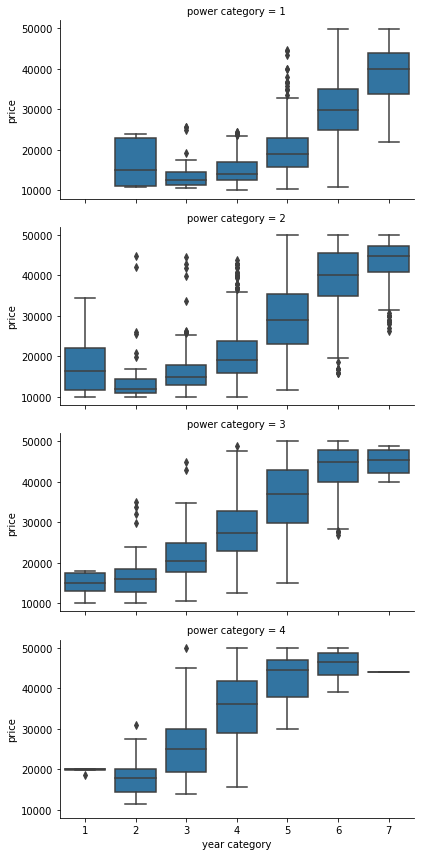

In [40]:
sns.FacetGrid(pd.concat([df,df2],axis=1),row='power category',aspect=2).map(sns.boxplot,'year category','price')

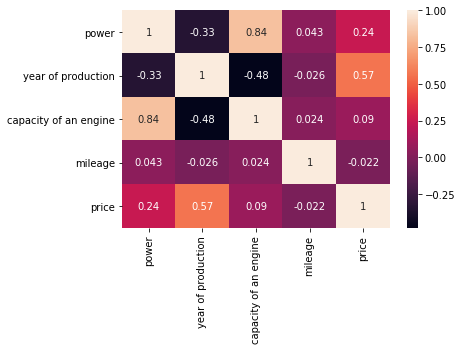

In [13]:
sns.heatmap(df[['power','year of production','capacity of an engine','mileage','price']].corr(),annot=True)

## model building

In [43]:
df1=df.drop(['brand','model','Oferta od','Rodzaj paliwa','Skrzynia biegów','Typ',
              'Okres gwarancji producenta','Kraj pochodzenia'],axis=1)

I have checked a different models and the best one was the Linear Regression. We will calculate root mean squared error in order to evaluate how good our model is performing.

In [59]:
from sklearn.model_selection import train_test_split
x=df1.drop('price',axis=1)
y=df1['price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model=LinearRegression()
model.fit(x_train,y_train)
pred=model.predict(x_test)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,pred))))

RMSE: 5708.6594291245565


## model 2

In this model we will remove outliers.

In [61]:
df1['mileage'].sort_values()

2082          163
5616          165
5925          911
1490         1500
6241         7000
5585         7200
3885         7782
7308         8574
4810         8600
4759         9000
4711         9041
6268         9041
3781        10341
4106        10885
6321        10937
3187        11000
6040        11000
6995        11500
6631        11500
4653        11500
5556        12072
4556        12128
2464        12257
4774        12441
5371        12900
6813        13000
4326        13000
6706        13000
6045        13655
4625        14078
          ...    
5263       389400
1469       392000
4564       392895
4091       396000
5502       397000
967        397757
897        399914
943        400000
6733       417800
6799       420000
6774       424000
1500       427000
4280       434715
3444       440000
2861       440000
1574       465000
5419       470241
389        474500
2595       496000
4377       496000
572        496000
1222       497000
5395       497192
1012       516000
648       

In [62]:
df1=df1[df1['mileage']<=519332]

(array([ 407., 1103., 1887., 2015., 1184.,  497.,  146.,   50.,    8.,
           9.]), array([1.630000e+02, 5.207990e+04, 1.039968e+05, 1.559137e+05,
        2.078306e+05, 2.597475e+05, 3.116644e+05, 3.635813e+05,
        4.154982e+05, 4.674151e+05, 5.193320e+05]), <a list of 10 Patch objects>)

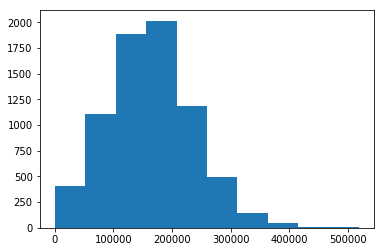

In [63]:
plt.hist(df1['mileage'])

(array([1.000e+01, 1.952e+03, 3.893e+03, 1.032e+03, 2.650e+02, 1.050e+02,
        3.600e+01, 8.000e+00, 4.000e+00, 1.000e+00]),
 array([  5.,  57., 109., 161., 213., 265., 317., 369., 421., 473., 525.]),
 <a list of 10 Patch objects>)

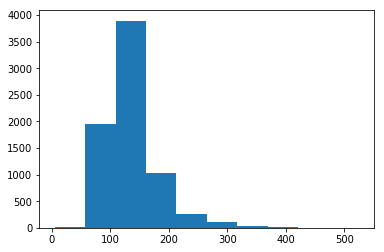

In [64]:
plt.hist(df1['power'])

(array([57., 66., 22., 17., 11.,  1.,  1.,  4.,  0.,  1.]),
 array([252. , 279.3, 306.6, 333.9, 361.2, 388.5, 415.8, 443.1, 470.4,
        497.7, 525. ]),
 <a list of 10 Patch objects>)

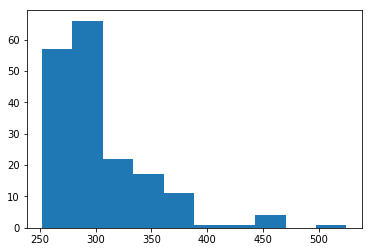

In [65]:
plt.hist(df1[df1['power']>250]['power'])

(array([  4.,   0.,   2.,   0.,   0.,   0.,   0.,   4.,  48., 105.]),
 array([ 5. , 11.4, 17.8, 24.2, 30.6, 37. , 43.4, 49.8, 56.2, 62.6, 69. ]),
 <a list of 10 Patch objects>)

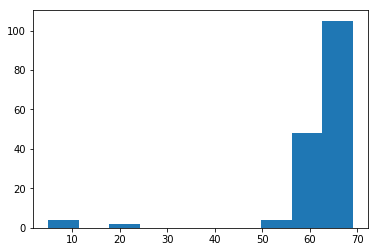

In [66]:
plt.hist(df1[df1['power']<70]['power'])

(array([ 588., 1447., 1857., 1822.,  809.,  311.,  169.,  121.,   56.,
          59.]),
 array([ 60. ,  84.6, 109.2, 133.8, 158.4, 183. , 207.6, 232.2, 256.8,
        281.4, 306. ]),
 <a list of 10 Patch objects>)

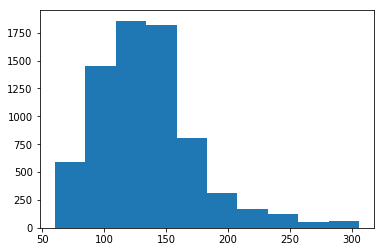

In [67]:
plt.hist(df1[(df1['power']>=56)&(df1['power']<=306)]['power'])

In [68]:
df1=df1[(df1['power']>=56)&(df1['power']<=306)]

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 8.000e+00, 5.000e+00, 1.200e+01, 2.100e+01,
        1.400e+01, 8.700e+01, 1.580e+02, 9.160e+02, 1.797e+03, 1.385e+03,
        1.734e+03, 1.095e+03]),
 array([1966. , 1968.6, 1971.2, 1973.8, 1976.4, 1979. , 1981.6, 1984.2,
        1986.8, 1989.4, 1992. , 1994.6, 1997.2, 1999.8, 2002.4, 2005. ,
        2007.6, 2010.2, 2012.8, 2015.4, 2018. ]),
 <a list of 20 Patch objects>)

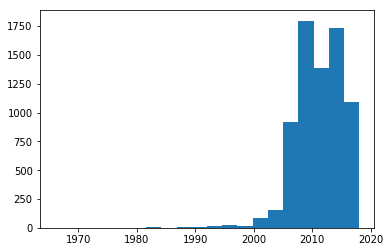

In [70]:
plt.hist(df1['year of production'],bins=20)

In [73]:
df1[df1['year of production']<=2002]['year of production'].value_counts()

2002    40
2001    25
2000    22
1999    11
1995     8
1997     8
1994     5
1992     5
1996     5
1989     4
1998     3
1991     3
1993     2
1990     2
1988     2
1987     2
1983     2
1978     2
1984     1
1980     1
1966     1
Name: year of production, dtype: int64

In [74]:
df1=df1[df1['year of production']>=2000]

In [76]:
from sklearn.model_selection import train_test_split
x=df1.drop('price',axis=1)
y=df1['price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model=LinearRegression()
model.fit(x_train,y_train)
pred=model.predict(x_test)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,pred))))

RMSE: 4468.731136393623


Let's see how a distribution of an error (error = |real price - predicted price|) looks like.

In [103]:
error=[]
for i in range(len(pred)):
    x=pred[i]
    y=y_test.values[i]
    error.append(abs(y-x))

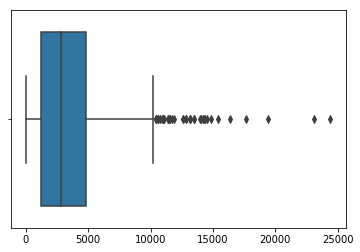

In [105]:
sns.boxplot(pd.DataFrame(error))

From this graph we can see that in 75% of cases the error was smaller than 5000 and in almost all cases the error was smaller 10000. 

Now we will define error as a ratio of a difference of prices to a real price (error = |real price - predicted price| / real price)

In [108]:
error=[]
for i in range(len(pred)):
    x=pred[i]
    y=y_test.values[i]
    error.append(abs(y-x)/y)

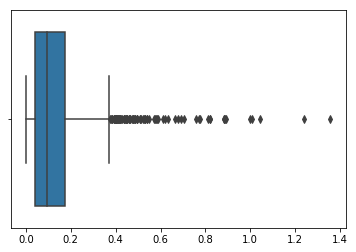

In [109]:
sns.boxplot(pd.DataFrame(error))

From this graph we can see that in 75% of cases the error was smaller than 20% of a real price and in almost all cases it was smaller than 40% of a real price.